# Time Series Analysis – Gray–Scott Reaction–Diffusion
This notebook performs a time series analysis of a spatiotemporal dataset generated by the Gray-Scott model. This mathematical system describes how the concentrations of two chemical substances, conventionally named A and B, evolve over a two-dimensional space and time.

## 1. Objective
Analyze a real spatiotemporal dataset (Gray–Scott reaction–diffusion) using autocorrelation, ARIMA, Fourier Transform, and Wavelet Transform.
****
## 2. Load Packages

In [2]:
!pip install the_well[benchmark]

  Using cached the_well-1.1.0-py3-none-any.whl.metadata (12 kB)
  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
  Using cached torch-2.8.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached neuraloperator-0.3.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached timm-1.0.20-py3-none-any.whl.metadata (61 kB)
  Using cached torch_harmonics-0.6.5-py3-none-any.whl.metadata (12 kB)
  Using cached wandb-0.17.9-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
  Using cached torchinfo-1.8.0-py3-none-any.whl.metadata (21 kB)
  Using cached huggingface_hub-0.35.3-py3-none-any.whl.metadata (14 kB)
  Using cached configmypy-0.2.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached tensorly-0.9.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached tensorly_torch-0.5.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange
from neuralop.models import FNO
from tqdm import tqdm

from the_well.benchmark.metrics import VRMSE
from the_well.data import WellDataset
from the_well.data.normalization import (  # noqa: F401
    RMSNormalization,
    ZScoreNormalization,
)
from the_well.utils.download import well_download

device = "cuda"
base_path = "./datasets"  # path/to/storage

## 3. Download Dataset
Use the tutorial from The Well GitHub repository to load the dataset `gray_scott_reaction_diffusion`.


In [3]:
#well_download(base_path=base_path, dataset="gray_scott_reaction_diffusion", split="train")
dataset = WellDataset(
    well_base_path=f"{base_path}/datasets",
    well_dataset_name="gray_scott_reaction_diffusion",
    well_split_name="train",
    n_steps_input=1000,
    n_steps_output=0,
    use_normalization=False,
)

print(len(dataset))

640


## 4. Select a Radom Trajectory

* The daatset has 120 repetitions.
* Select a random number `n` between 0 and 119.
* Extract the trajectory using:
```
x = dataset[n]["input_fields"]
```

* Confirm that `x` has shape `(2, 1000, 128, 128)`.

In [6]:
n = np.random.randint(0, 119)
print(f"repetition number: {n}")
#Complete Trajectory
x = dataset[n]["input_fields"]
print(x.shape)
x = x.permute(3, 0, 1, 2)
print(x.shape)

repetition number: 47
torch.Size([1000, 128, 128, 2])
torch.Size([2, 1000, 128, 128])


## 5. Extract Random Points
* Choose 3–5 random spatial points `(i, j)` in the 128×128 grid.
* For each point, extract the concentration of A:
  `series = x[0, :, i, j]`
* **Important:** In many cases, the time series will be almost flat and not very interesting. Play with different random points until you find curves with visible dynamics or patterns to analyze.
* Plot the time series for each selected point.

Point: ( 95 , 85 )



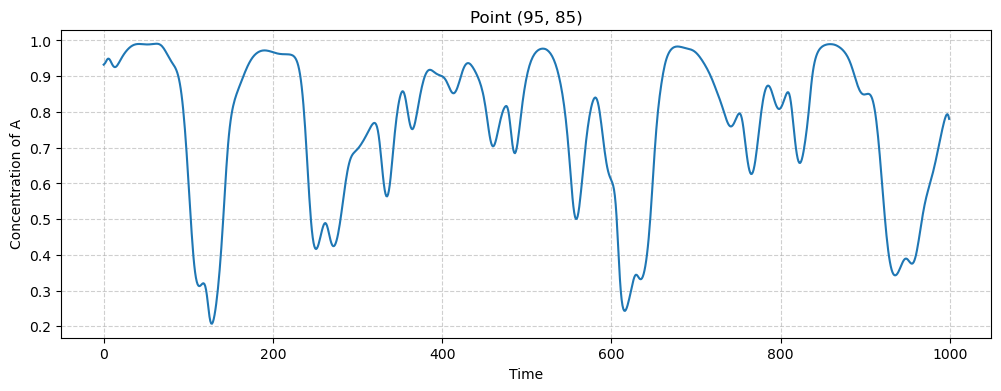

Point: ( 50 , 55 )



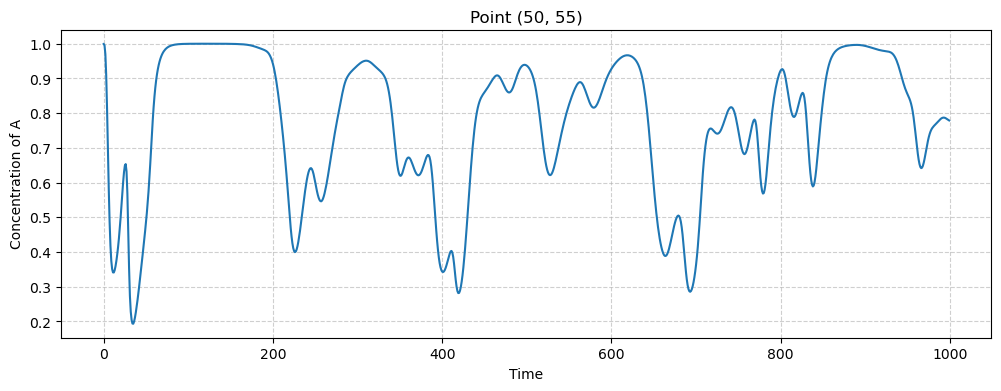

Point: ( 69 , 44 )



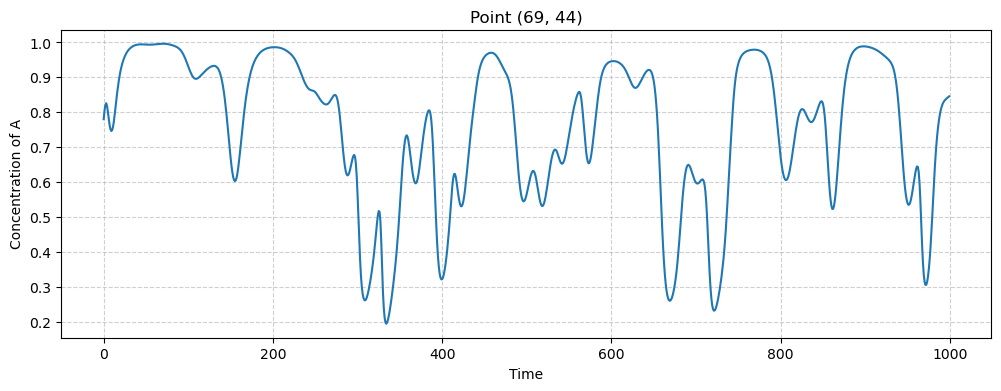

In [7]:
n_trials=3
arr_series = {}
coords = [] 
for k in range(n_trials):    
    i, j = np.random.randint(0, 128, size=2)
    #Chanel 0 (A), all time, poinit (i,j)
    series = x[0, :, i, j]
    arr_series[(i,j)] = series.numpy()
    coords.append((i,j))
    print("Point: (",i,",",j,")\n" )
    plt.figure(figsize=(12,4))
    plt.title(f"Point ({i}, {j})")
    plt.plot(series.numpy())
    plt.xlabel("Time")
    plt.ylabel("Concentration of A")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

## 6. Autocorrelation Analysis
* Compute and plot the autocorrelation function for each selected point.
* Interpret whether the signal is strongly correlated over time.

[(95, 85), (50, 55), (69, 44)]
(50, 55)
1000


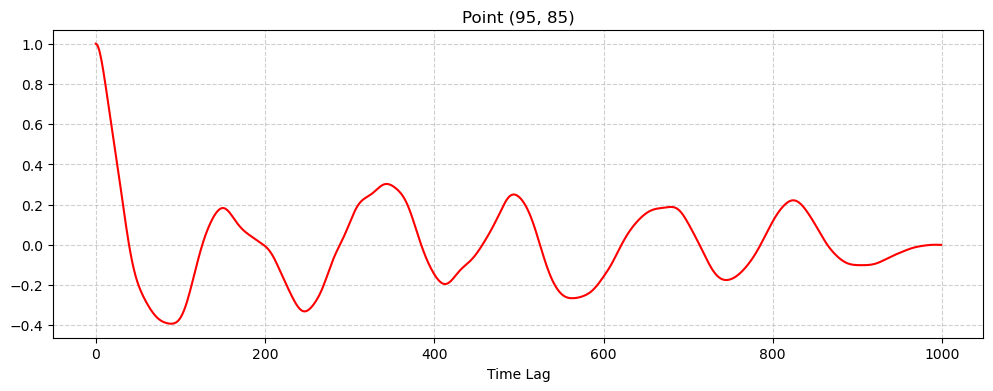

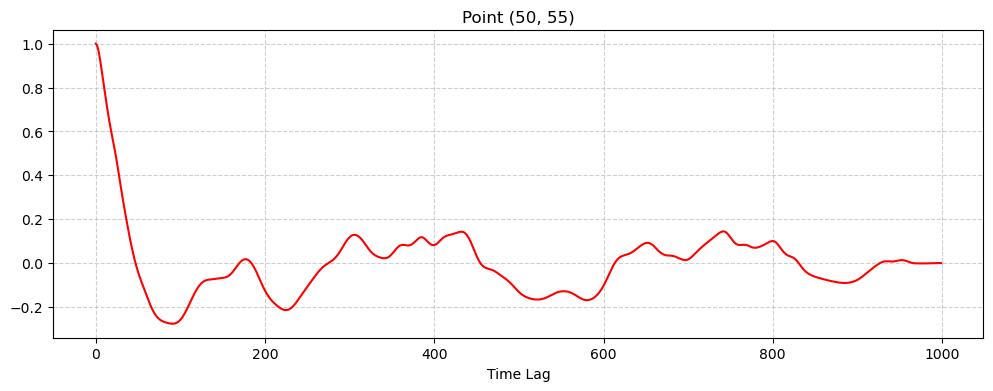

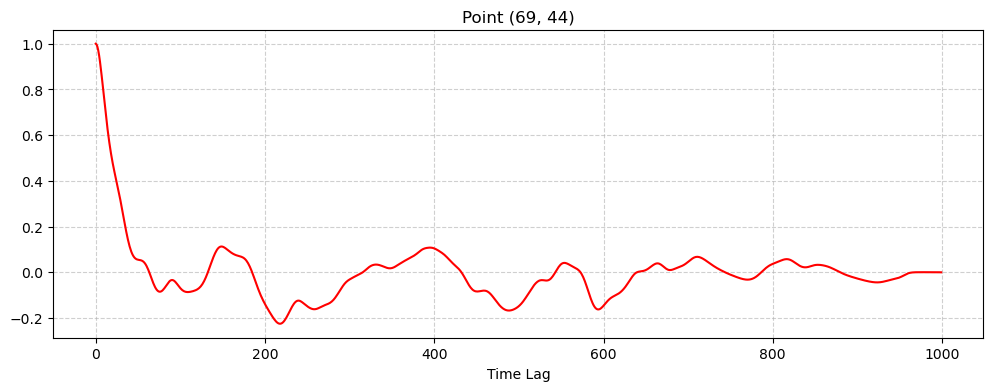

In [8]:
print(coords)
print(coords[1])
print(np.size(arr_series[coords[1]]))
for coor, i_serie in arr_series.items():
    x_c = i_serie - np.mean(i_serie)
    acf = np.correlate(x_c, x_c, mode='full')
    acf = acf[acf.size//2:] / np.max(acf)
    plt.figure(figsize=(12,4))
    plt.title(f"Point {coor}")
    plt.plot(acf, label='Autocorrelation', color = 'red')
    plt.xlabel("Time Lag")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


* Figure 1, corresponding to point (95, 85), displays an ACF that decays towards zero in an oscillatory way. The significant correlation during different lags, suggests a strong-correlation in the concentration of A sample in this space.
* Figure 2, corresponding to point (50, 55), exhibits a behavior comparable to the previous case, but with a considerable decrease in the amplitude of the oscilation. This suggest that in this point, the system shows a lower correlation of A sample concentration.
* Figure 3, corresponding to point (69, 44), decays to zero more faster than in the previous figures. This suggests that the dynamics at this point are faster and less predicatable. It could be asociated to a region of high chemical reactvity.

## 7. ARIMA Modeling
* Fit an ARIMA model to each time series.
* Compare different `(p, d, q)` orders and choose the best using AIC.
* Plot the original series and fitted values.

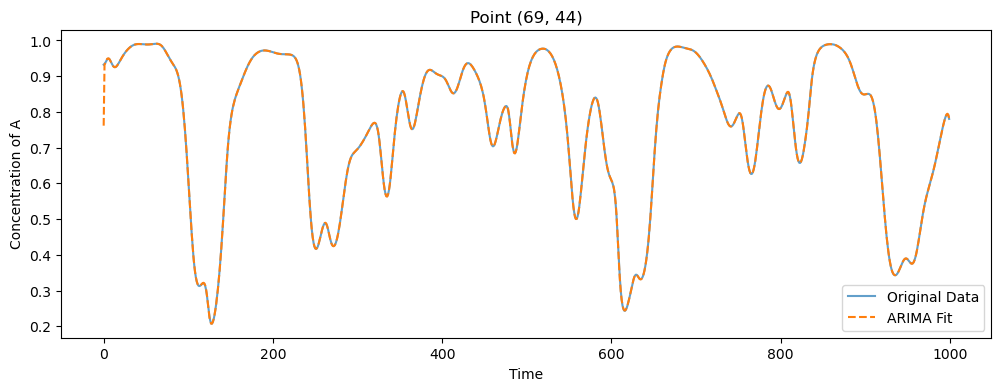

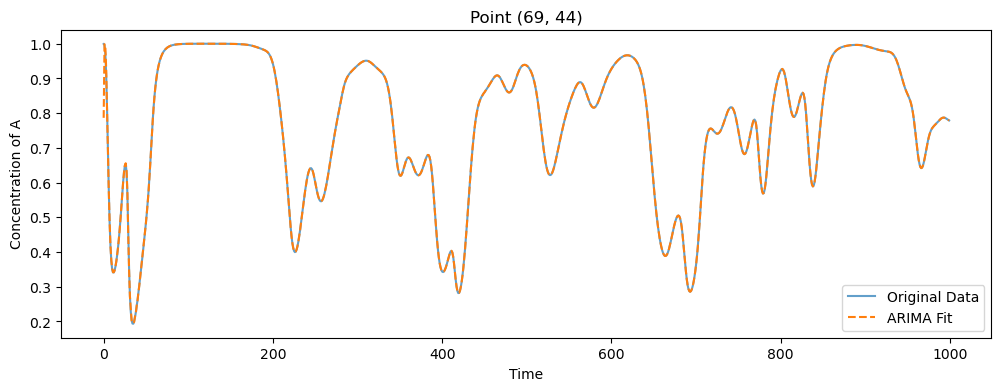

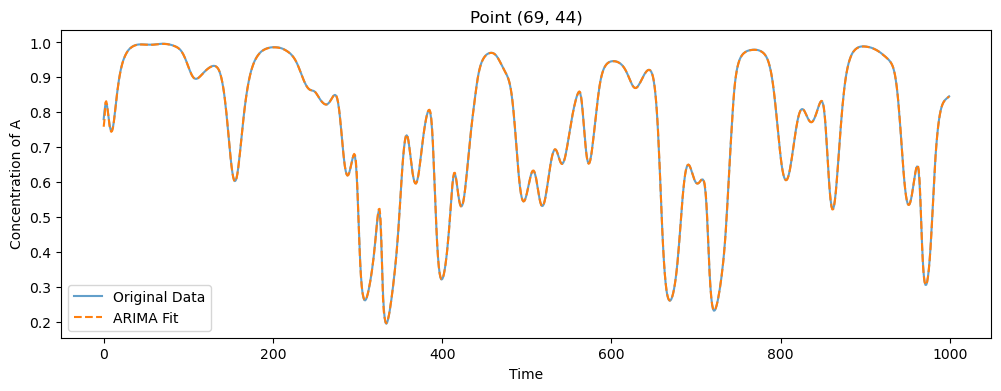

In [16]:
import statsmodels.api as sm
for coor, i_serie in arr_series.items():
    x = i_serie
    model = sm.tsa.ARIMA(x, order=(3, 0, 3))
    result = model.fit()
    predictions = result.fittedvalues

    plt.figure(figsize=(12,4))
    plt.title(f"Point ({i}, {j})")
    plt.plot(x, label="Original Data", alpha = 0.7)
    plt.plot(predictions, label="ARIMA Fit", linestyle = '--',linewidth = 1.5)
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Concentration of A")
    plt.show()
#    print(result.summary())

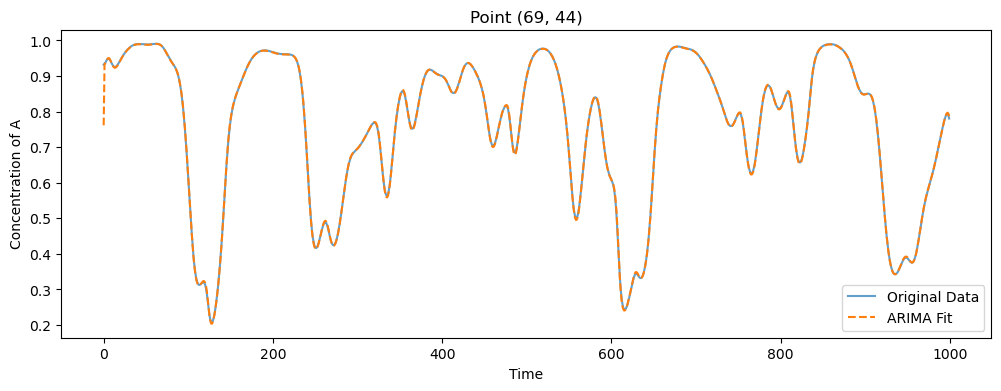

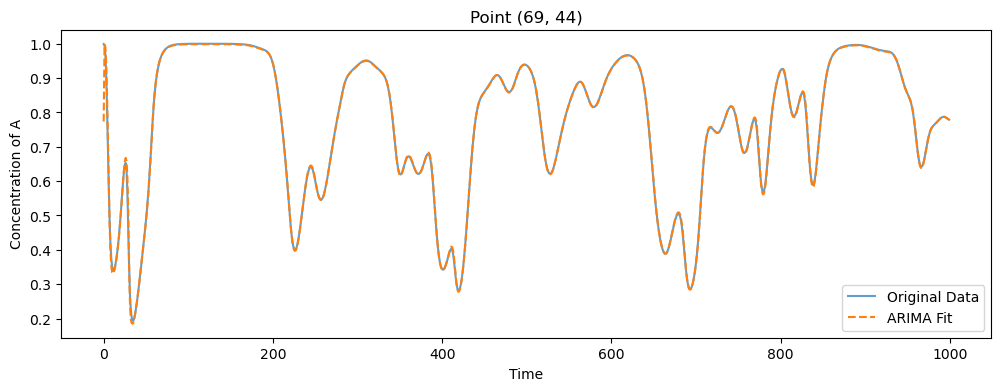

/home/alejo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


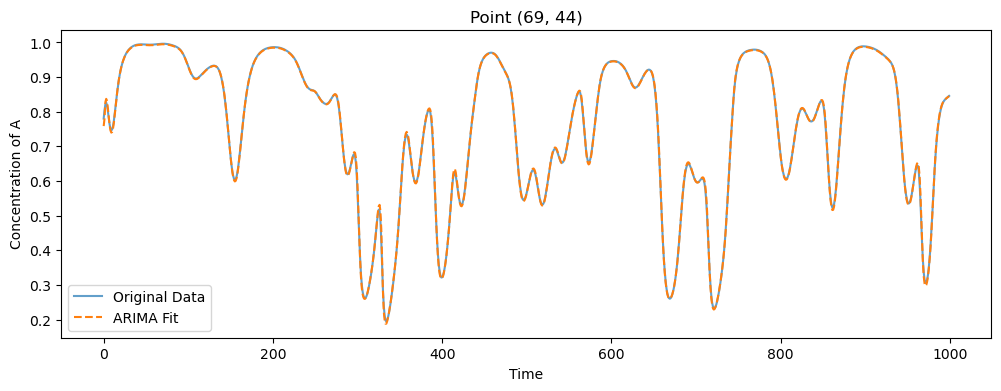

In [13]:
for coor, i_serie in arr_series.items():
    x = i_serie
    model = sm.tsa.ARIMA(x, order=(2, 0, 0))
    result = model.fit()
    predictions = result.fittedvalues

    plt.figure(figsize=(12,4))
    plt.plot(i_serie, label="Original Data", alpha = 0.7)
    plt.plot(predictions, label="ARIMA Fit", linestyle = '--',linewidth = 1.5)
    plt.legend()
    plt.title(f"Point ({i}, {j})")
    plt.xlabel("Time")
    plt.ylabel("Concentration of A")
    plt.show()

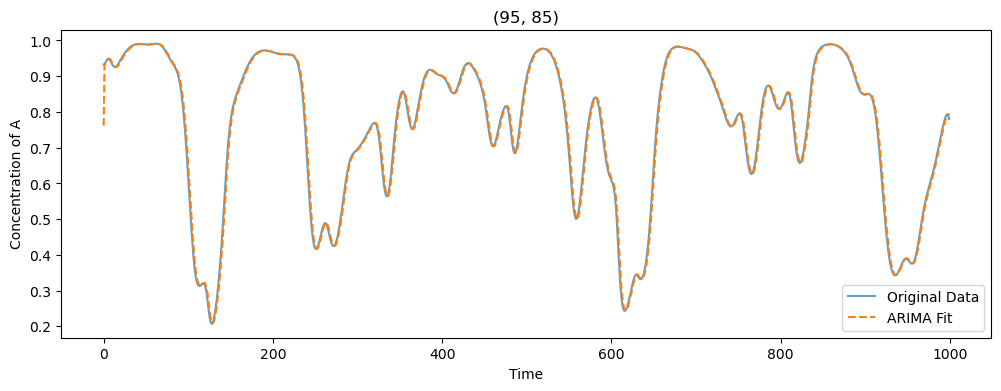

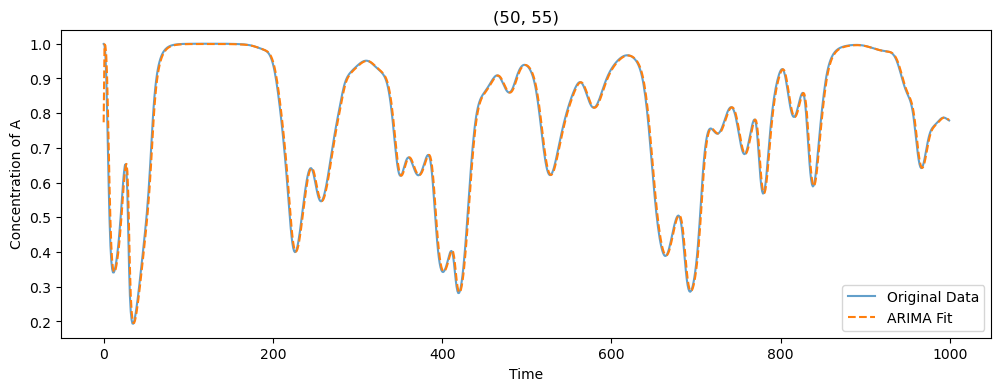

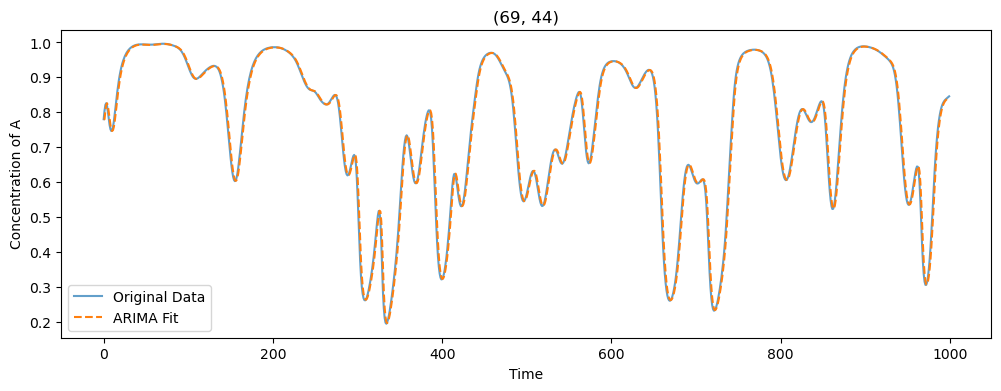

In [27]:
for coor, i_serie in arr_series.items():
    x = i_serie
    model = sm.tsa.ARIMA(x, order=(1, 0, 0))
    result = model.fit()
    predictions = result.fittedvalues

    plt.figure(figsize=(12,4))
    plt.plot(i_serie, label="Original Data", alpha = 0.7)
    plt.plot(predictions, label="ARIMA Fit", linestyle = '--',linewidth = 1.5)
    plt.legend()
    plt.title(f"{coor}")
    plt.xlabel("Time")
    plt.ylabel("Concentration of A")
    plt.show()

All models fit well. Anyway, the ARIMA(1,0,0) Fit reveals that the system posses a short-tem memory, where the cocnentration at any moment is primarly predicted by its value at the immediately preceding time step, and it suggest that the time series does not present a trend or bias (is stationary, d=0), and there are not shot-terms fluctations and noise in the system (q=0).

## 8. Fourier Transform
* Apply the FFT to each time series.
* Plot the frequency spectrum.
* Identify dominant frequencies and discuss physical meaning.

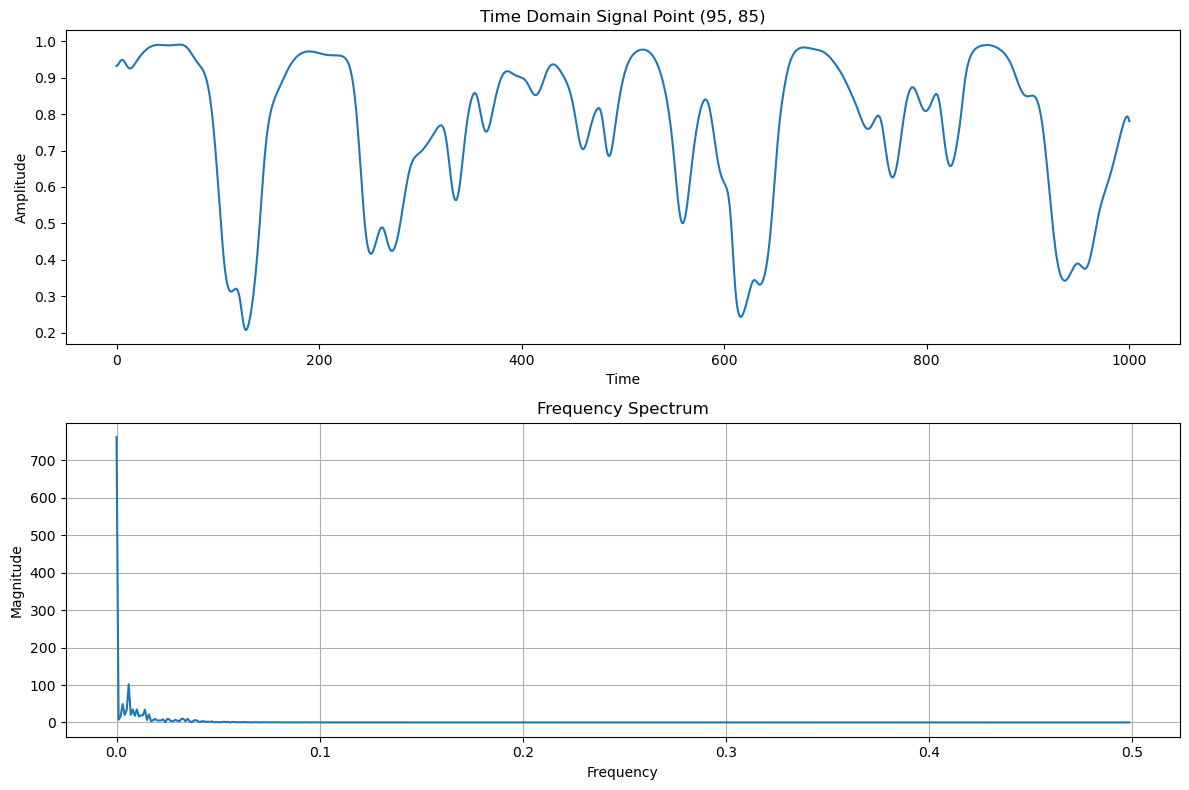

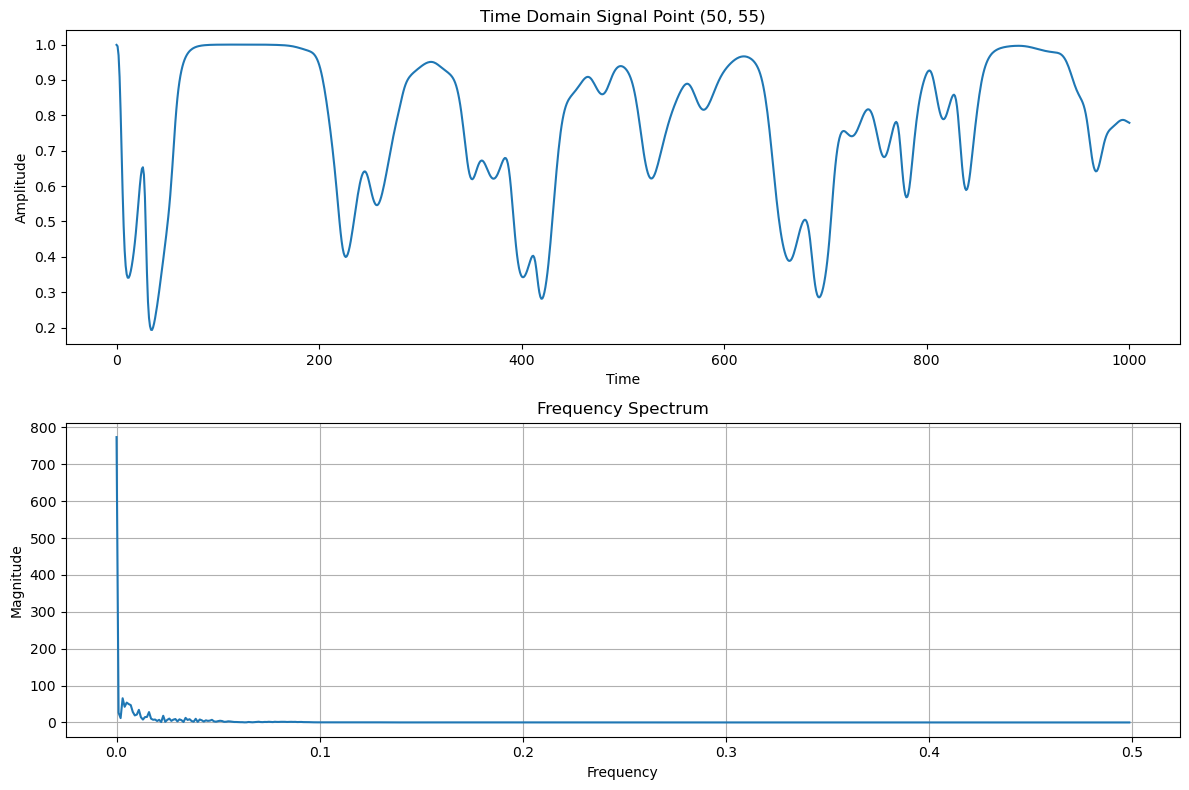

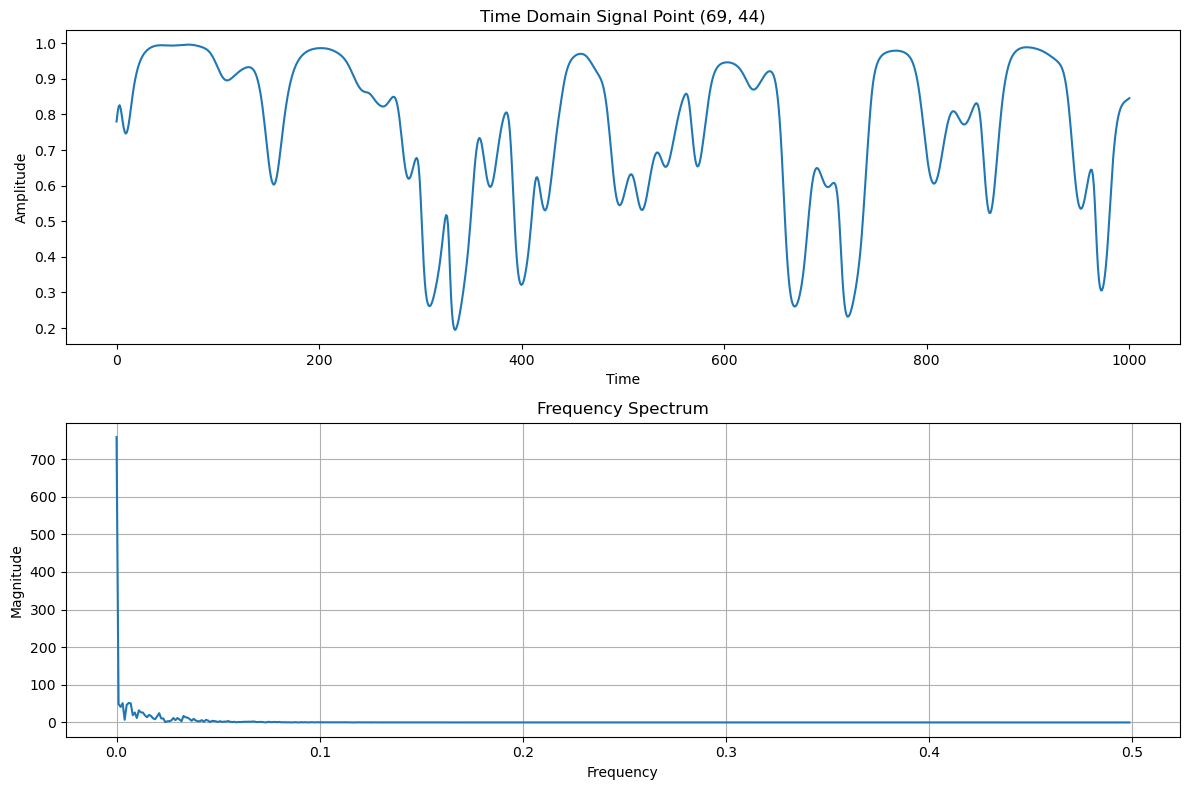

In [24]:
from numpy.fft import fft, fftfreq
for coor, i_serie in arr_series.items():
    t = np.linspace(0, 1000, 1000)
    yf = fft(i_serie)
    xf = fftfreq(len(t), t[1]-t[0])
    #Plot frequency spectrum
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t, i_serie)
    plt.title(f"Time Domain Signal Point {coor}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    
    plt.subplot(2, 1, 2)
    plt.plot(xf[:len(i_serie)//2], np.abs(yf[:len(i_serie)//2]))
    plt.title("Frequency Spectrum")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    
    plt.tight_layout()
    plt.grid(True)
    plt.show()

The frequency spectrum fot all the time series reveals that teh system's dynamics are dominated by low frequecny components. The large peak at zero frequency represent the mean concentration of sample A ath the analyzed point. Then it shows oscillatory behaviore in a narrow band of low frequencies. These are the dominant frequency of the systems. 

## 9. Wavelet Transform
* Perform a Continuous Wavelet Transform (CWT) using a Morlet or Complex Morlet wavelet.
* Plot the scalogram.
* Highlight when and where bursts of activity occur.

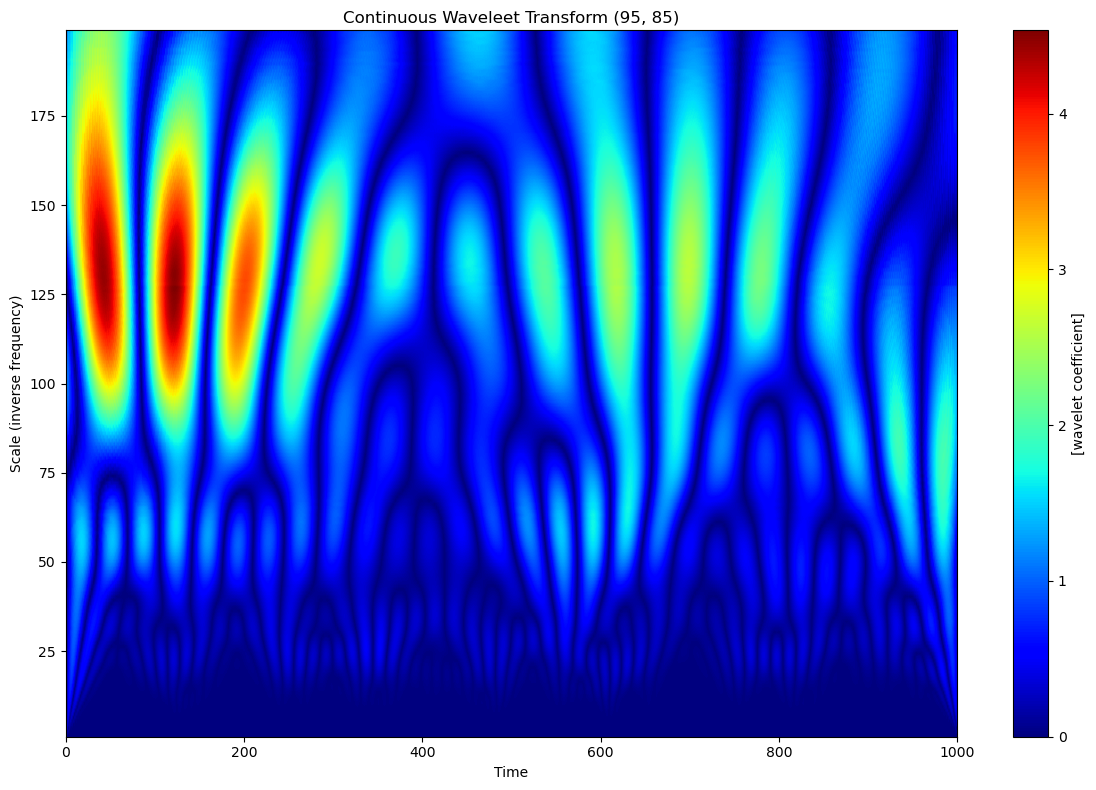

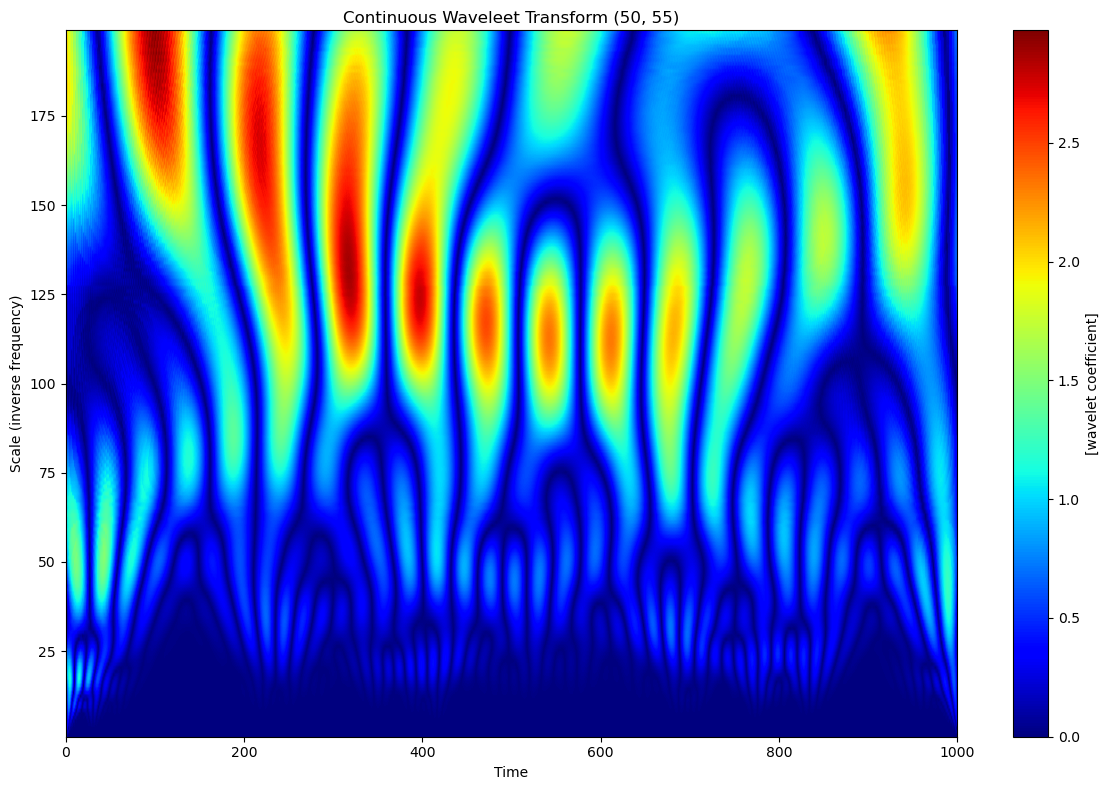

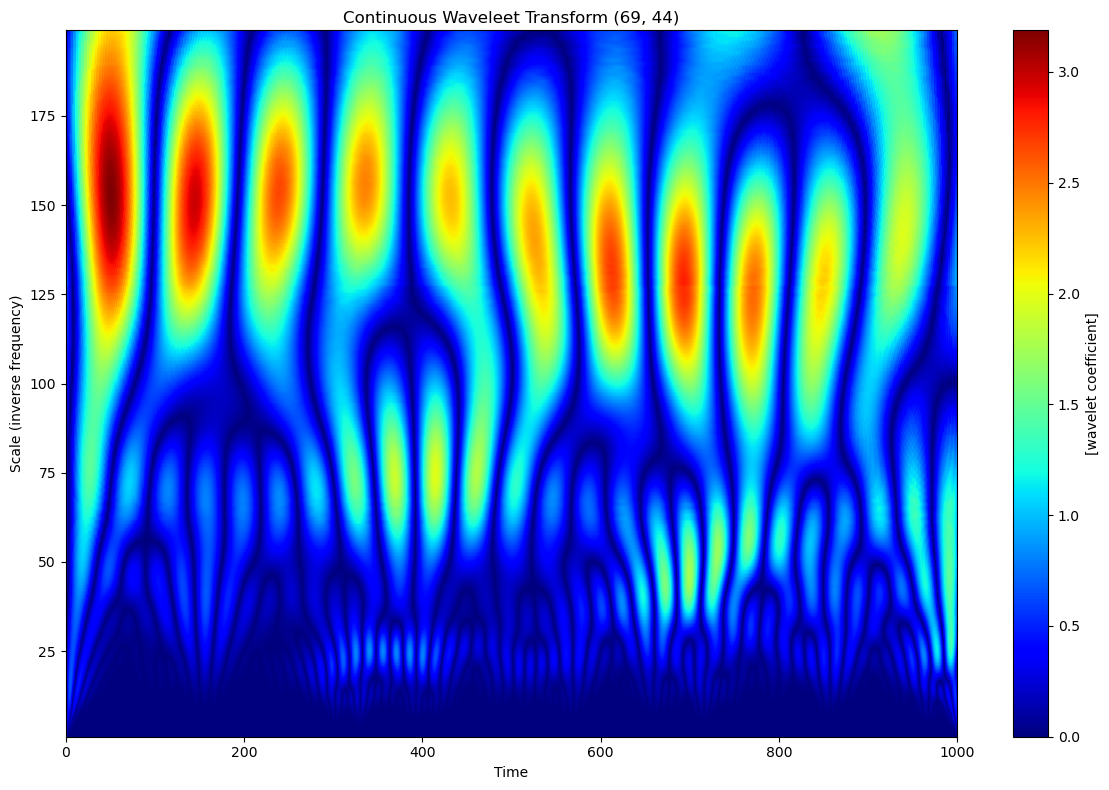

In [28]:
import pywt
for coor, i_serie in arr_series.items():
        
    scales=np.arange(1, 200)
    coeffs, freqs = pywt.cwt(i_serie, scales, 'morl', sampling_period=t[1]-t[0])
    #Create time-frequency plot
    plt.figure(figsize=(12, 8))
  #  plt.subplot(2, 1, 1)
  #  plt.plot(t, i_serie, 'r-', linewidth=2, label='True Signal')
  #  plt.title('Original Signal')
  #  plt.xlabel('Time')
  #  plt.ylabel("Concentration of A")
  #  plt.legend()
    
  #  plt.subplot(2, 1, 2)
    plt.imshow(np.abs(coeffs), extent=[t.min(), t.max(), 1, len(scales)], cmap='jet', aspect='auto', origin='lower')
    plt.colorbar(label='[wavelet coefficient]')
    plt.title(f'Continuous Waveleet Transform {coor}')
    plt.xlabel('Time')
    plt.ylabel('Scale (inverse frequency)')

    
    plt.tight_layout()
    plt.show()

    



Fig 1:
A significant brust is observed in the time series around 50, 100, and 200 time-units. This transient is primarly concentrated in the low-frequency range. 
Fig 2:
A significant brust is observed in the time series around 150, 300, and 400 time-units. This transient is primarly concentrated in the low/mid-frequency range, but higher frequency than thefirst time-serie. 
Fig 3:
Multiple significant brust are observed in the time series around 50, 150, 200, 600 and 700 time-units. This transient is primarly concentrated in the low/mid-frequency range, but higher frequency than thefirst time-serie, and similar to second time serie. 

## 10. Discussion
* Compare results from different points.
A common thread across all three points is that their dynamics are dominated by low-frequency components. This shared foundation suggests a universal characteristic of the system: a strong, but very short-term, correlation.

(95,85): Its ACF plot shows a very slow, high-amplitude oscillatory decay, indicating the strongest and longest-lasting temporal correlation. The corresponding wavelet scalogram reinforces this, showing a few, well-defined bursts of energy concentrated at the highest scales (lowest frequencies), signifying slow, large-scale dynamic events.

(69,44): Its ACF decays to zero most rapidly, signifying the shortest "memory." The wavelet scalogram is the most compelling evidence: it is densely populated with numerous, frequent bursts. 

(50,55): ts ACF decays faster than at (95, 85) but slower than at (69, 44). Its wavelet scalogram shows more activity than the first point but less frenetic, higher-frequency behavior than the third.

* Discuss differences between high and low concentration regions.
* Suggest physical interpretations of observed patterns.

(95,85): Stability and predictability. The concentration of species A is high. Here, the dynamics are slow. The oscillations are broad and predictable because the point is far from the chaotic influence of the main reaction sites.

(69,44): High activity and low predictability. This point is located on the dynamic edge of a pattern (a spot, stripe, or spiral) where species B is rapidly consuming species A. 

(50,55): Intermediate case.
